In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from netCDF4 import Dataset
import glob, sys

#sys.path.append('../../PythonTools')
#import PlotTools.ScientificCbar

In [2]:
##
# Get a list of all of the files and extract the filter scales
##

filter_files = glob.glob('filter_*.nc')
filter_scales = np.array([ Dataset(fp).filter_scale for fp in filter_files ])

# Re-sort the files according to filter scale
inds = np.argsort( filter_scales )
filter_files  = [ filter_files[ind] for ind in inds ]
filter_scales = filter_scales[inds]

In [3]:
##
#   Also load in the original data
##

with Dataset( 'velocity_sample.nc', 'r' ) as dset:

    x = dset['longitude'][:] / 1e3
    y = dset['latitude' ][:] / 1e3

    uo = dset['uo'][0,0,:,:]
    vo = dset['vo'][0,0,:,:]

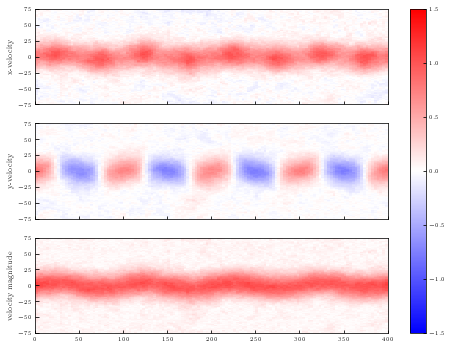

In [4]:
fig, axes = plt.subplots( 3, 1, sharex = True, sharey = True, figsize = (7,5), 
                                gridspec_kw = dict( left = 0.075, right = 0.95, bottom = 0.05, top = 0.95 ) )

plot_params = dict( vmin = -1.5, vmax = 1.5, cmap = 'bwr', rasterized = True )

qm = axes[0].pcolormesh( x, y, uo,                       **plot_params )
axes[1].pcolormesh( x, y, vo,                       **plot_params )
axes[2].pcolormesh( x, y, np.sqrt( uo**2 + vo**2 ), **plot_params )

plt.colorbar( qm, ax = axes )

axes[0].set_ylabel( 'x-velocity' )
axes[1].set_ylabel( 'y-velocity' )
axes[2].set_ylabel( 'velocity magnitude' )

plt.savefig('unfiltered_fields.pdf', dpi = 250)

In [5]:
##
#   Plot Filtered Fields
##

if len(filter_files) > 4:
    print('More than 4 filter scales used. Will only plot the smallest four.')

# A list of the variables that we'll plot
variables = [   ('coarse_KE', 'log'), 
                ('fine_KE', 'log'), 
                ('Pi', 'lin'), 
                ('fine_u_lon', 'lin'),
                ('fine_u_lat', 'lin'),
                ('coarse_u_lon', 'lin'),
                ('coarse_u_lat', 'lin')
            ]

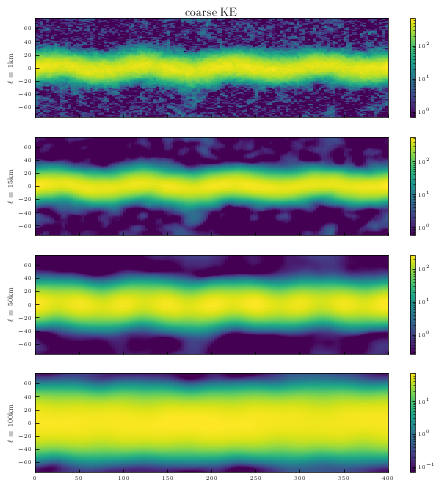

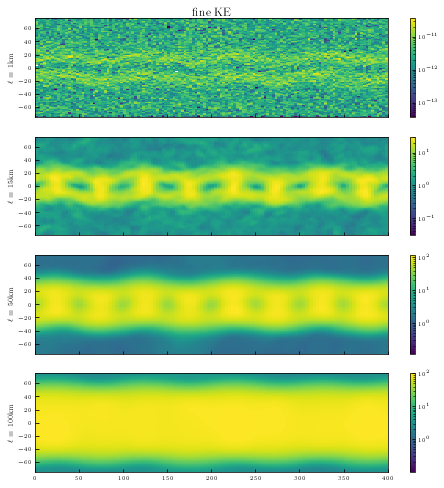

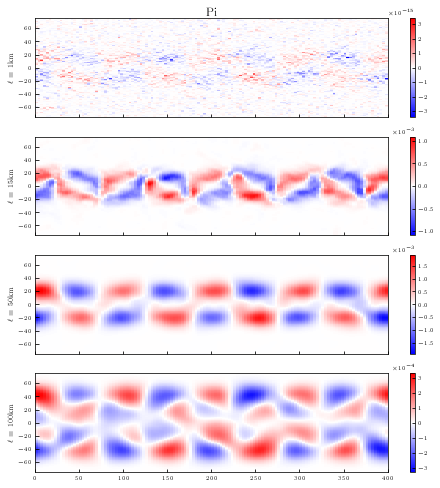

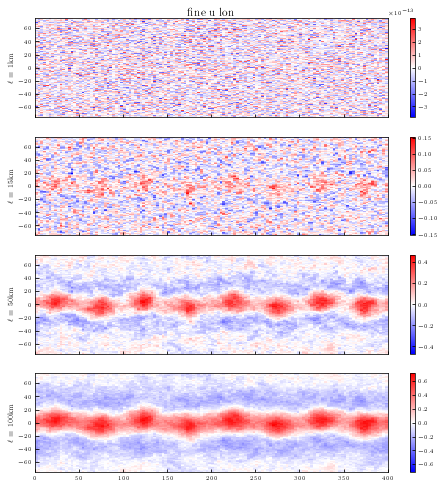

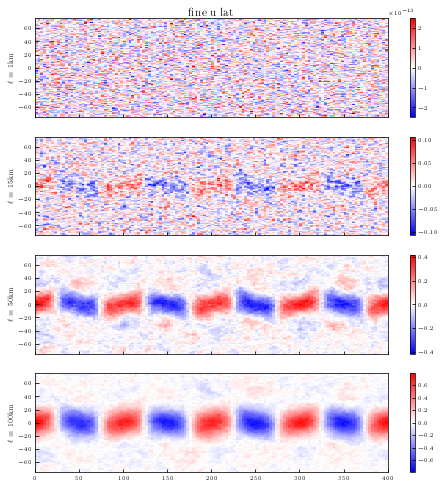

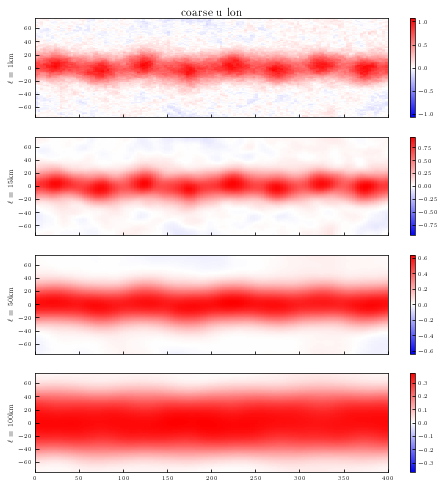

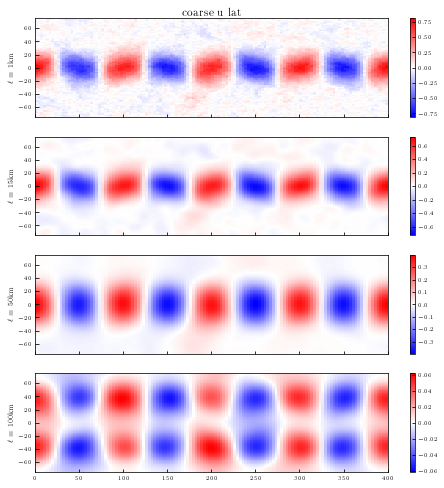

In [11]:
for var, kind in variables:

    fig, axes = plt.subplots( 4, 1, sharex = True, sharey = True, figsize = (7,7), 
                                gridspec_kw = dict( left = 0.075, right = 0.95, bottom = 0.05, top = 0.95 ) )

    qms = np.zeros( axes.shape, dtype = 'object' )

    for ii in range( max(4, len(filter_scales))):

        axes[ii].set_ylabel('$\ell$ = {0:g}km'.format( filter_scales[ii] / 1e3 ))

        with Dataset( filter_files[ii], 'r' ) as dset:
            x = dset['longitude'][:] / 1e3
            y = dset['latitude' ][:] / 1e3

            # Dimension order is time (t) - depth (z) - latitude (y) - longitude (x)
            data = dset[var][0,0,:,:]


        cv = np.max(np.abs(data))
        if kind == 'lin':
            norm = colors.Normalize( vmin = -cv, vmax = cv )
            cmap = 'bwr'
        elif kind == 'log':
            norm = colors.LogNorm( vmin = cv / 1e3, vmax = cv)
            cmap = 'viridis'
        elif kind == 'symlog':
            norm = colors.SymLogNorm( vmin = -cv, vmax = cv, linthresh = cv / 1e3 )
            cmap = 'bwr'

        qms[ii] = axes[ii].pcolormesh(x, y, data, norm = norm, cmap = cmap, rasterized = True)

    for q, ax in zip( qms, axes ):
        cbar = plt.colorbar( q, ax = ax )
        #if kind == 'lin':
        #    PlotTools.ScientificCbar( cbar )

    axes[0].set_title(var.replace('_', ' '), fontsize = 12)
        
    plt.savefig( var + '.pdf', dpi = 250 )